# About Dataset

## Data Source

Synthetic data generated from the Wharton Class of 2025's statistics.

## Metadata

- **application_id**: Unique identifier for each application
- **gender**: Applicant's gender (Male, Female)
- **international**: International student (TRUE/FALSE)
- **gpa**: Grade Point Average of the applicant (on 4.0 scale)
- **major**: Undergraduate major (Business, STEM, Humanities)
- **race**: Racial background of the applicant (e.g., White, Black, Asian, Hispanic, Other / null: international student)
- **gmat**: GMAT score of the applicant (800 points)
- **work_exp**: Number of years of work experience (Year)
- **work_industry**: Industry of the applicant's previous work experience (e.g., Consulting, Finance, Technology, etc.)
- **admission**: Admission status (Admit, Waitlist, Null: Deny)

# EDA

## General Analysis with Ydata Profiling

In [15]:
from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mutual_info_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold

In [16]:
df = pd.read_csv('dataset/MBA.csv')
# profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
# profile.to_file('report.html')

## Feature Importance

For training purpose, let's replace the Waitlist value by Admit change the admission column to a binary format.

In [17]:
df.fillna(value={'race':  "Unknown"}, inplace=True)

In [18]:
categorical = ['gender', 'international', 'major', 'race', 'work_industry']
numerical = ['gpa', 'gmat', 'work_exp']
df.loc[df['admission'] == 'Waitlist', 'admission'] = 'Admit'
df['admission'] = (df['admission'] == 'Admit').astype(int)
overall_admission = df.admission.mean()
overall_admission

np.float64(0.16144656118824668)

Now, let's evaluate how each categorical feature affects the likelihood of admission.

In [19]:
for category in categorical:
    data_category = df.groupby(category).admission.agg(mean='mean', count='count')
    # difference: represents how much the group's admission rate differs from the overall average admission rate (overall_admission).
    data_category['difference'] = data_category['mean'] - overall_admission
    # risk_ratio: indicates how much more or less likely a group is to be admitted compared to the overall average.
    data_category['risk_ratio'] = data_category['mean'] / overall_admission
    display(data_category)
    print()

,mean,count,difference,risk_ratio
gender,,,,
Female,0.222124,2251,0.060677,1.375833
Male,0.126807,3943,-0.034640,0.785443


,mean,count,difference,risk_ratio
international,,,,
False,0.159007,4352,-0.002439,0.984892
True,0.167210,1842,0.005763,1.035696


,mean,count,difference,risk_ratio
major,,,,
Business,0.158868,1838,-0.002578,0.984030
Humanities,0.164450,2481,0.003003,1.018602
STEM,0.160000,1875,-0.001447,0.991040


,mean,count,difference,risk_ratio
race,,,,
Asian,0.184830,1147,0.023383,1.144837
Black,0.098253,916,-0.063193,0.608581
Hispanic,0.117450,596,-0.043997,0.727483
Other,0.210970,237,0.049524,1.306751
Unknown,0.167210,1842,0.005763,1.035696
White,0.185440,1456,0.023993,1.148613


,mean,count,difference,risk_ratio
work_industry,,,,
CPG,0.184211,114,0.022764,1.141000
Consulting,0.158740,1619,-0.002707,0.983235
Energy,0.093750,32,-0.067697,0.580688
Financial Services,0.210643,451,0.049196,1.304723
Health Care,0.143713,334,-0.017734,0.890156
Investment Banking,0.155172,580,-0.006274,0.961138
Investment Management,0.222892,166,0.061445,1.380590
Media/Entertainment,0.152542,59,-0.008904,0.944847
Nonprofit/Gov,0.150538,651,-0.010909,0.932430


In [20]:
df[categorical].apply(lambda x: mutual_info_score(x, df['admission'])).sort_values()

major            0.000023
international    0.000052
work_industry    0.001364
race             0.004419
gender           0.007527
dtype: float64

In [21]:
df[numerical].corrwith(df.admission).sort_values()

work_exp    0.006821
gpa         0.289618
gmat        0.353645
dtype: float64

# Split the data into train, test and validation sets

We will split the data set into three parts: training, validation and test. 20% of the data will be used for testing, and the remaining 80% will be split into training and validation sets (75% for training and 25% for validation).

In [22]:
data_full_train, data_test = train_test_split(df, test_size=0.2)
data_train, data_val = train_test_split(data_full_train, test_size=0.25)

print(len(df))
print(f"train: {len(data_train)}, val: {len(data_val)}, test: {len(data_test)}")

6194
train: 3716, val: 1239, test: 1239


In [23]:
data_train = data_train.reset_index(drop=True)
data_val = data_val.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

In [24]:
y_train = data_train.admission.values
y_val = data_val.admission.values
y_test = data_test.admission.values

Ensure that the input data used to train and validate the model does not contain the response that the model should predict.

In [25]:
del data_train["admission"]
del data_val["admission"]
del data_test["admission"]

# Features ROC AUC

The ROC AUC score, or Receiver Operating Characteristic Area Under the Curve score, is a performance measurement for classification models at various threshold settings. It is particularly useful for binary classification problems.

## Key Concepts

1. ROC Curve: The ROC curve is a graphical representation that illustrates the diagnostic ability of a binary classifier as its discrimination threshold is varied. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR).
    True Positive Rate (TPR): Also known as sensitivity or recall, it is the ratio of correctly predicted positive observations to all actual positives.
    False Positive Rate (FPR): It is the ratio of incorrectly predicted positive observations to all actual negatives.
2. AUC (Area Under the Curve): The AUC quantifies the overall ability of the model to discriminate between the positive and negative classes. The value of AUC ranges from 0 to 1:
    AUC = 0.5: The model has no discrimination capability (equivalent to random guessing).
    AUC < 0.5: The model is performing worse than random guessing.
    AUC = 1: The model perfectly discriminates between the positive and negative classes.

## Interpretation

A higher AUC value indicates a better model performance. Generally, an AUC score above 0.7 is considered acceptable, above 0.8 is considered good, and above 0.9 is considered excellent.


gpa: 0.7426696874159704


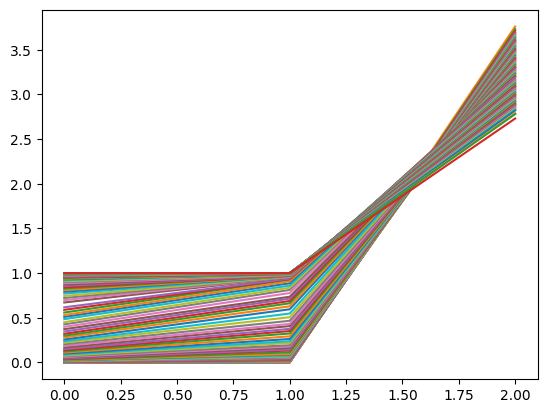

gmat: 0.780809576848405


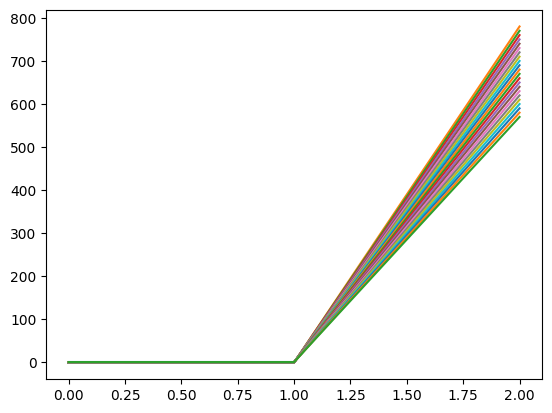

work_exp: 0.5056890367399096


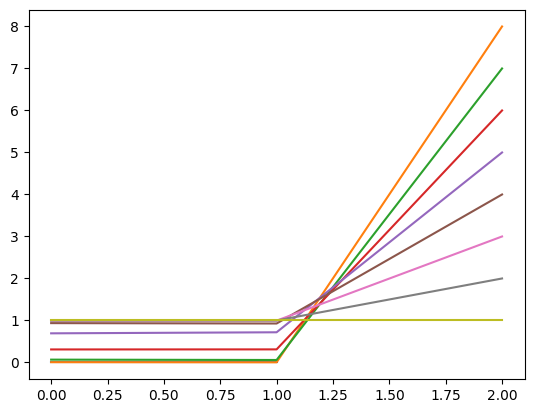

In [26]:
for col in numerical:
    auc = roc_auc_score(data_full_train.admission, data_full_train[col])
    if auc < 0.5:
        auc = roc_auc_score(data_full_train.admission, -data_full_train[col])
    print(f"{col}: {auc}")
    plt.plot(roc_curve(data_full_train.admission, data_full_train[col]))
    plt.show()

In [ ]:
features = ["gender", "gpa", "race", "gmat", "work_industry"]